In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn import svm
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression, RFE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor

In C:\Users\Syber-Viper\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\Syber-Viper\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\Syber-Viper\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [ ]:
#os.system("kaggle competitions download -c blg454e-summer-2021")

In [2]:
sample_submission_loc = "blg454e-summer-2021/sampleSubmission.csv"
test_t0_loc = "blg454e-summer-2021/test_t0.csv"
train_t0_loc = "blg454e-summer-2021/train_t0.csv"
train_t1_loc = "blg454e-summer-2021/train_t1.csv"

In [3]:
test_t0_data = pd.read_csv(test_t0_loc)
train_t0_data = pd.read_csv(train_t0_loc)
train_t1_data = pd.read_csv(train_t1_loc)

In [4]:
def draw_scatter(data, x_range, y_range):
    fig, axs = plt.subplots(x_range, y_range)
        
    for i in range(x_range):
        for j in range(y_range):
            rand_temp = np.random.randint(0, len(data))
            axs[i, j].scatter(range(len(data[data.columns[rand_temp]])), data[data.columns[rand_temp]], c=np.random.rand(len(data[data.columns[rand_temp]])))
            axs[i, j].set_title(rand_temp)
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

In [5]:
def draw_hist(data, x_range, y_range):
    
    fig, axs = plt.subplots(x_range, y_range)
    
    for i in range(x_range):
        for j in range(y_range):
            rand_temp = np.random.randint(0, len(data))
            axs[i, j].hist(data[data.columns[rand_temp]])
            axs[i, j].set_title(rand_temp)
            
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        

In [6]:
def draw_corr(data):
    plt.matshow(data.corr())
    plt.show()

In [7]:
def scatter_hist_helper(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    
def scatter_hist(data, f_1, f_2):
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005
    
    
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]
    
    # start with a square Figure
    fig = plt.figure(figsize=(8, 8))
    
    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    
    # use the previously defined function
    scatter_hist_helper(data[data.columns[f_1]], data[data.columns[f_2]], ax, ax_histx, ax_histy)
    
    plt.show()

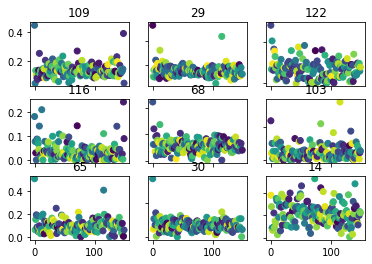

In [8]:
draw_scatter(train_t0_data, 3, 3)

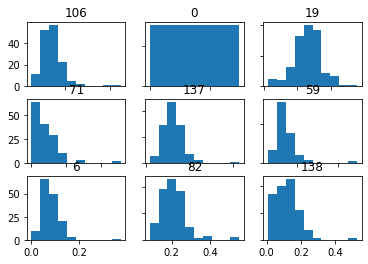

In [22]:
draw_hist(train_t0_data, 3, 3)

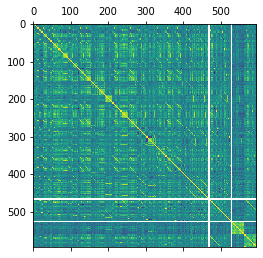

In [10]:
draw_corr(train_t0_data)

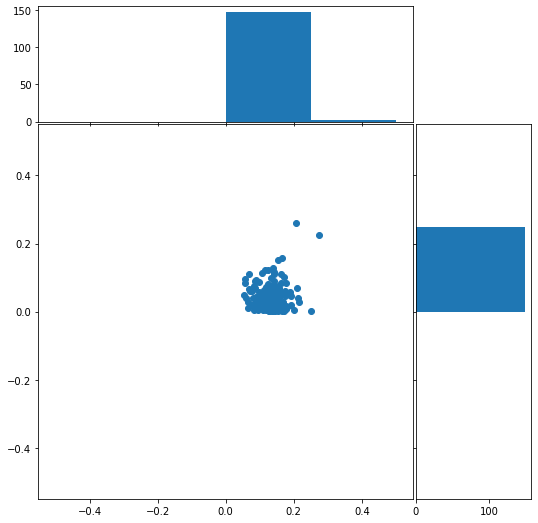

In [11]:
scatter_hist(train_t0_data, 10, 120)

In [12]:
def try_models(train,train_labels,test,test_labels, results):

    def test_model(model):

        model.fit(train, train_labels)
        test_predict = model.predict(test)
        actual = test_labels.flatten()
        predicted = test_predict.flatten()
        scores = mse(predicted, actual)

        return scores

    model = linear_model.LinearRegression()
    test_result = test_model(model)
    model_name = 'LinearRegression'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = linear_model.Ridge()
    test_result = test_model(model)
    model_name = 'Ridge'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = MultiOutputRegressor(SGDRegressor())
    test_result = test_model(model)
    model_name = 'SGDRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = MultiOutputRegressor(linear_model.BayesianRidge())
    test_result = test_model(model)
    model_name = 'BayesianRidge'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = MultiOutputRegressor(linear_model.HuberRegressor())
    test_result = test_model(model)
    model_name = 'HuberRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = linear_model.Lasso(alpha=1e-4)
    test_result = test_model(model)
    model_name = 'Lasso'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
        
    model = BaggingRegressor()
    test_result = test_model(model)
    model_name = 'BaggingRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = ElasticNet()
    test_result = test_model(model)
    model_name = 'ElasticNet'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = RandomForestRegressor()
    test_result = test_model(model)
    model_name = 'RandomForestRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})

    model = MultiOutputRegressor(AdaBoostRegressor())
    test_result = test_model(model)
    model_name = 'AdaBoostRegressor'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    model = MultiOutputRegressor(svm.SVR(kernel="linear"))
    test_result = test_model(model)
    model_name = 'SVR(kernel="linear")'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
       
    model = MultiOutputRegressor(svm.SVR(kernel="rbf"))
    test_result = test_model(model)
    model_name = 'SVR(kernel="rbf")'
    if model_name in results.keys():
        results[model_name].append(test_result)
    else:
        results.update({model_name:[test_result]})
    
    return results

In [13]:
random.seed(1)
def cv(data, labels, n_fold, model=None, shuffle=False):
    kf = KFold(n_splits=n_fold, shuffle=shuffle)
    results = {}
    if model is not None:
        results['YourModel'] = []
    for train_index, test_index in kf.split(data):
        train = data[train_index, :]
        train_labels = labels[train_index, :]
        test = data[test_index, :]
        test_labels = labels[test_index, :]

        scaler = MinMaxScaler()
        scaler.fit(train)
        train = scaler.transform(train)
        test = scaler.transform(test)

        pca = PCA(0.70)
        pca.fit(train)
        train = pca.transform(train)
        test = pca.transform(test)

        if model == None:
            results = try_models(train,train_labels,test,test_labels, results)
        else:
            model.fit(train, train_labels)
            test_predict = model.predict(test)
            actual = test_labels.flatten()
            predicted = test_predict.flatten()
            scores = mse(predicted, actual)
            results['YourModel'].append(scores)

    results_df = pd.DataFrame(results).T
    variance = results_df.var(axis=1)
    mean = results_df.mean(axis=1)
    results_df.insert(5, "Var", variance)
    results_df.insert(6, "Mean", mean)  

    return results_df

In [14]:
def train_model_and_predict(model, data, labels, test):
    scaler = StandardScaler()
    scaler.fit(data)
    train = scaler.transform(data)

    pca = PCA(0.70)
    pca.fit(train)
    train = pca.transform(train)
    model.fit(train, labels)
    
    test_data = scaler.transform(test)
    test_data = pca.transform(test_data)
    prediction = model.predict(test_data)

    return model, prediction

<h2>TRAIN_T0 ANALYSIS<h2>

In [15]:
train_t0_data.head()

,ID,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f586,f587,f588,f589,f590,f591,f592,f593,f594,f595
0,0,0.193382,0.096121,0.289502,0,0.193382,0.096121,0.273247,0.466629,0.177126,...,0.110908,0.193465,0.186630,0.174750,0.096996,0.242103,0.042979,0.015484,0.015484,0.048103
1,1,0.014410,0.064584,0.050174,0,0.014410,0.064584,0.115367,0.100957,0.050783,...,0.101471,0.028694,0.187073,0.111753,0.100301,0.089273,0.099579,0.013585,0.013585,0.243097
2,2,0.070879,0.077238,0.148117,0,0.070879,0.077238,0.162528,0.233407,0.085291,...,0.085059,0.160802,0.142508,0.114494,0.080725,0.054955,0.084518,0.046046,0.046046,0.126800
3,3,0.012150,0.053557,0.065708,0,0.012150,0.053557,0.135480,0.147630,0.081922,...,0.066011,0.034460,0.122039,0.094287,0.062342,0.067846,0.080307,0.007430,0.007430,0.218388
4,4,0.035510,0.072512,0.037002,0,0.035510,0.072512,0.056819,0.021309,0.015693,...,0.098395,0.117918,0.121873,0.096543,0.081662,0.109835,0.055561,0.017878,0.017878,0.232787


In [16]:
print(train_t0_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Columns: 596 entries, ID to f595
dtypes: float64(589), int64(7)
memory usage: 698.5 KB
None


In [17]:
train_t0_data.describe()

,ID,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f586,f587,f588,f589,f590,f591,f592,f593,f594,f595
count,150.000000,150.000000,150.000000,150.000000,150.0,150.000000,150.000000,150.000000,150.000000,150.000000,...,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,74.500000,0.044582,0.080598,0.071282,0.0,0.044582,0.080598,0.131620,0.115131,0.061869,...,0.105047,0.100972,0.172020,0.136881,0.127180,0.121855,0.109727,0.029184,0.029184,0.240352
std,43.445368,0.037994,0.039930,0.050766,0.0,0.037994,0.039930,0.037942,0.064775,0.046194,...,0.041862,0.059288,0.056443,0.047358,0.045876,0.042679,0.042027,0.026718,0.026718,0.078478
min,0.000000,0.000089,0.001989,0.000940,0.0,0.000089,0.001989,0.054214,0.000020,0.000580,...,0.012323,0.005157,0.007663,0.011979,0.030873,0.003749,0.014510,0.000395,0.000395,0.042528
25%,37.250000,0.017879,0.056915,0.032421,0.0,0.017879,0.056915,0.108719,0.068408,0.024877,...,0.076577,0.054555,0.135979,0.102224,0.093079,0.089561,0.080658,0.010046,0.010046,0.194399
50%,74.500000,0.033523,0.076158,0.061955,0.0,0.033523,0.076158,0.130866,0.115870,0.056490,...,0.101955,0.091981,0.158843,0.132284,0.123985,0.120384,0.107655,0.020933,0.020933,0.244233
75%,111.750000,0.059201,0.100670,0.099729,0.0,0.059201,0.100670,0.155715,0.155132,0.085909,...,0.131724,0.135250,0.201340,0.164686,0.155491,0.150561,0.131991,0.041979,0.041979,0.301425
max,149.000000,0.214443,0.375598,0.289502,0.0,0.214443,0.375598,0.273247,0.466629,0.242402,...,0.218610,0.299961,0.414848,0.345963,0.346058,0.242103,0.262390,0.186477,0.186477,0.465477


In [18]:
train_t1_clean = train_t0_data.drop("ID", 1)
train_t1_clean = train_t1_data.drop("ID", 1)
test_t0_clean = test_t0_data.drop("ID", 1)

<h4>Feature Dropping With LocalOutlierFactor<h4>

In [19]:
clf = LocalOutlierFactor(n_neighbors=5)
outlier_loc = clf.fit_predict(train_t1_clean)

C:\Users\Syber-Viper\Anaconda3\lib\site-packages\sklearn\neighbors\lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


In [20]:
clf.negative_outlier_factor_

array([-1.19730729, -1.00299901, -1.19414664, -1.02065054, -1.08732756,
       -1.2121961 , -1.13684092, -0.98777652, -1.23827503, -1.067434  ,
       -1.00947535, -0.99943032, -1.35251513, -1.16654134, -1.45315815,
       -1.01926469, -1.28329071, -1.1364423 , -2.93441591, -1.00571024,
       -1.04954081, -1.3506161 , -1.16091947, -1.43640372, -0.95785991,
       -1.11280671, -1.10195575, -1.06003395, -1.35542374, -1.12731619,
       -1.21157611, -1.05188104, -1.05299254, -1.01004729, -1.13359523,
       -0.99959409, -1.26768672, -1.20484856, -1.00506718, -1.23135417,
       -1.17014683, -1.66312491, -1.00876147, -1.02475754, -0.99071529,
       -1.22887565, -1.04278697, -1.0613255 , -1.00442831, -1.17715913,
       -1.34851439, -1.07993558, -1.20637674, -1.00026475, -1.2730956 ,
       -1.0032024 , -1.20423312, -1.12227065, -1.10617133, -1.01305571,
       -1.20314543, -0.99946456, -0.96695935, -1.16794428, -1.42447304,
       -1.13308057, -1.01621505, -1.35822129, -1.26425331, -1.02

In [21]:
#train_t1_clean = np.delete(train_t1_clean, outlier_loc, 1)

C:\Users\Syber-Viper\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  


ValueError: Shape of passed values is (150, 594), indices imply (150, 595)